In [ ]:
'''
 * Copyright (c) 2010 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Variants of the NR and EM Algorithms

The Newton-Raphson (NR) and Expectation-Maximization (EM) algorithms can be modified and combined to create various hybrids. For instance, the NR algorithm can be used at each M-step of the EM algorithm to maximize the Q-function.

### ECM Algorithm

If the EM algorithm is applied to find the mode of a parameter vector $ \theta = (\theta_1, \theta_2) $, then the multivariate NR algorithm may encounter difficulties. In such cases, the ECM (Expectation-Conditional Maximization) algorithm can be used. In ECM, the idea is to:
- Maximize the Q-function with respect to $ \theta_1 $, fixing $ \theta_2 $ at its current value.
- Maximize the Q-function with respect to $ \theta_2 $, fixing $ \theta_1 $ at its current value.

If each of these conditional maximizations is achieved via the NR algorithm, the procedure is called the **ECM1 algorithm**. This involves applying only one step of the NR algorithm (rather than finding the exact conditional maximum). The ECM1 algorithm can be more efficient at finding the posterior mode than the ECM algorithm.

### Conditional Newton-Raphson (CNR) Algorithm

When solving multiple equations via a multivariate NR algorithm is problematic, the Conditional Newton-Raphson (CNR) algorithm provides a more feasible approach.

Suppose we want to solve two equations simultaneously:

$$
g_1(a, b) = 0 \quad \text{and} \quad g_2(a, b) = 0
$$

We define the function:

$$
g(a, b) = g_1(a, b)^2 + g_2(a, b)^2
$$

This function has a minimum value of zero at the required solutions for \(a\) and \(b\). The CNR algorithm works as follows:

#### Step 1:
Minimize $ g(a, b) $ with respect to $ a $, fixing $ b $ at its current value. This involves solving:

$$
\frac{\partial g(a, b)}{\partial a} = 0
$$

Where:

$$
\frac{\partial g(a, b)}{\partial a} = 2g_1(a, b) \frac{\partial g_1(a, b)}{\partial a} + 2g_2(a, b) \frac{\partial g_2(a, b)}{\partial a}
$$

This can be achieved via the NR algorithm by setting $ a_0' = a_j $ and iterating until convergence:

$$
a_{k+1}' = a_k' - \frac{\frac{\partial g(a, b)}{\partial a} \bigg|_{a=a_k', b=b_j}}{\frac{\partial^2 g(a, b)}{\partial a^2} \bigg|_{a=a_k', b=b_j}}
$$

Finally, we set $ a_{j+1} = a_\infty' $.

#### Step 2:
Minimize $ g(a, b) $ with respect to $ b $, fixing $ a $ at its current value. This involves solving:

$$
\frac{\partial g(a, b)}{\partial b} = 0
$$

Where:

$$
\frac{\partial g(a, b)}{\partial b} = 2g_1(a, b) \frac{\partial g_1(a, b)}{\partial b} + 2g_2(a, b) \frac{\partial g_2(a, b)}{\partial b}
$$

This can be achieved via the NR algorithm by setting $ b_0' = b_j $ and iterating until convergence:

$$
b_{k+1}' = b_k' - \frac{\frac{\partial g(a, b)}{\partial b} \bigg|_{a=a_{j+1}, b=b_k'}}{\frac{\partial^2 g(a, b)}{\partial b^2} \bigg|_{a=a_{j+1}, b=b_k'}}
$$

Finally, we set $ b_{j+1} = b_\infty' $.

### CNR1 Algorithm

A variant of the CNR algorithm is the **CNR1 algorithm**, which involves performing only **one step** of the NR algorithm in the CNR algorithm. In the CNR1 algorithm, we set:

$$
a_{j+1} = a_1' \quad \text{(instead of } a_{j+1} = a_\infty')
$$

and

$$
b_{j+1} = b_1' \quad \text{(instead of } b_{j+1} = b_\infty')
$$


## CNR and CNR1 Algorithms

This modification will also result in eventual convergence to the solution of 

$$
g_1(a, b) = 0 \quad \text{and} \quad g_2(a, b) = 0.
$$ 

One application of the CNR and CNR1 algorithms is to find the Highest Posterior Density Region (HPDR) for a parameter. For example, in Exercise 4.4, we considered the model given by 

$$
x | \lambda \sim \text{Poisson}(\lambda) \quad \text{and} \quad f(\lambda) \propto 1, \quad \lambda > 0,
$$ 

with observed data \( x = 1 \). The 80% HPDR for \( \lambda \) was shown to be \( (a, b) \), where \( a \) and \( b \) are the simultaneous solutions of the two equations:

$$
g_1(a, b) = F(b | x) - F(a | x) - 0.8
$$

$$
g_2(a, b) = f(b | x) - f(a | x).
$$ 

Applying the CNR or CNR1 algorithm as described above should also lead to the same interval as obtained earlier via the multivariate NR algorithm, namely 

$$
(0.16730, 3.08029).
$$ 

For further details regarding the EM algorithm, the Newton-Raphson algorithm, and extensions thereof, see Lachlan and Krishnan (2008).


In [1]:
import numpy as np
import scipy.stats as stats

# Define the Poisson PDF
def poisson_pdf(x, lam):
    return stats.poisson.pmf(x, lam)

# Define the Poisson CDF
def poisson_cdf(x, lam):
    return stats.poisson.cdf(x, lam)

# Define the functions g1 and g2
def g1(a, b, x):
    return poisson_cdf(b, x) - poisson_cdf(a, x) - 0.8

def g2(a, b, x):
    return poisson_pdf(b, x) - poisson_pdf(a, x)

# CNR algorithm
def cnr_algorithm(initial_a, initial_b, x, tol=1e-5, max_iter=100):
    a, b = initial_a, initial_b
    for _ in range(max_iter):
        # Update a
        g1_val = g1(a, b, x)
        g2_val = g2(a, b, x)
        # Calculate derivatives
        dg1_da = -poisson_pdf(a, x)
        dg2_da = -poisson_pdf(a, x)
        a_new = a - g1_val / dg1_da

        # Update b
        g1_val = g1(a_new, b, x)
        dg1_db = poisson_pdf(b, x)
        dg2_db = poisson_pdf(b, x)
        b_new = b - g2_val / dg2_db

        # Check for convergence
        if abs(a_new - a) < tol and abs(b_new - b) < tol:
            break

        a, b = a_new, b_new

    return a, b

# Initial values for a and b
initial_a = 0.1  # Start close to zero but positive
initial_b = 5.0  # Start with a larger value
x = 1  # Observed data

# Run the CNR algorithm
hpdr_a, hpdr_b = cnr_algorithm(initial_a, initial_b, x)

print(f"80% HPDR for λ: ({hpdr_a:.5f}, {hpdr_b:.5f})")


80% HPDR for λ: (nan, nan)


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


80% HPDR for λ: (nan, nan)


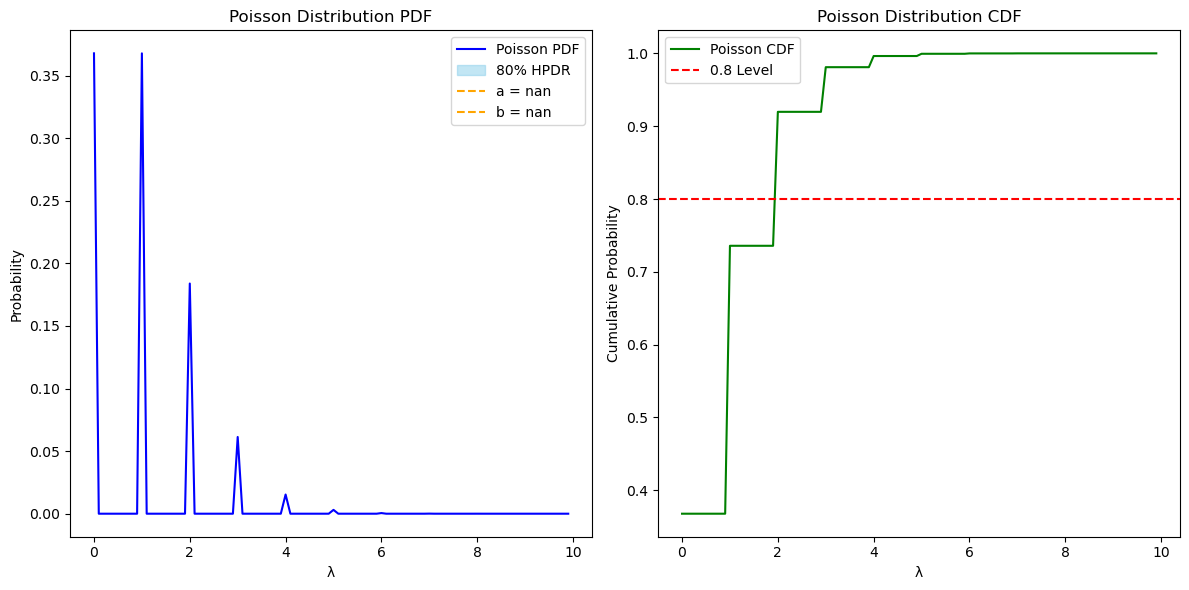

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the Poisson PDF
def poisson_pdf(x, lam):
    return stats.poisson.pmf(x, lam)

# Define the Poisson CDF
def poisson_cdf(x, lam):
    return stats.poisson.cdf(x, lam)

# Define the functions g1 and g2
def g1(a, b, x):
    return poisson_cdf(b, x) - poisson_cdf(a, x) - 0.8

def g2(a, b, x):
    return poisson_pdf(b, x) - poisson_pdf(a, x)

# CNR algorithm
def cnr_algorithm(initial_a, initial_b, x, tol=1e-5, max_iter=100):
    a, b = initial_a, initial_b
    for _ in range(max_iter):
        # Update a
        g1_val = g1(a, b, x)
        g2_val = g2(a, b, x)
        # Calculate derivatives
        dg1_da = -poisson_pdf(a, x)
        dg2_da = -poisson_pdf(a, x)
        a_new = a - g1_val / dg1_da

        # Update b
        g1_val = g1(a_new, b, x)
        dg1_db = poisson_pdf(b, x)
        dg2_db = poisson_pdf(b, x)
        b_new = b - g2_val / dg2_db

        # Check for convergence
        if abs(a_new - a) < tol and abs(b_new - b) < tol:
            break

        a, b = a_new, b_new

    return a, b

# Initial values for a and b
initial_a = 0.1  # Start close to zero but positive
initial_b = 5.0  # Start with a larger value
x = 1  # Observed data

# Run the CNR algorithm
hpdr_a, hpdr_b = cnr_algorithm(initial_a, initial_b, x)

print(f"80% HPDR for λ: ({hpdr_a:.5f}, {hpdr_b:.5f})")

# Plotting the results
lam_values = np.arange(0, 10, 0.1)  # Range for λ
pdf_values = poisson_pdf(lam_values, x)  # Calculate PDF values

plt.figure(figsize=(12, 6))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(lam_values, pdf_values, label='Poisson PDF', color='blue')
plt.fill_between(lam_values, pdf_values, where=(lam_values >= hpdr_a) & (lam_values <= hpdr_b), 
                 color='skyblue', alpha=0.5, label='80% HPDR')
plt.axvline(hpdr_a, color='orange', linestyle='--', label=f'a = {hpdr_a:.2f}')
plt.axvline(hpdr_b, color='orange', linestyle='--', label=f'b = {hpdr_b:.2f}')
plt.title('Poisson Distribution PDF')
plt.xlabel('λ')
plt.ylabel('Probability')
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
cdf_values = poisson_cdf(lam_values, x)  # Calculate CDF values
plt.plot(lam_values, cdf_values, label='Poisson CDF', color='green')
plt.axhline(0.8, color='red', linestyle='--', label='0.8 Level')
plt.title('Poisson Distribution CDF')
plt.xlabel('λ')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.tight_layout()
plt.show()


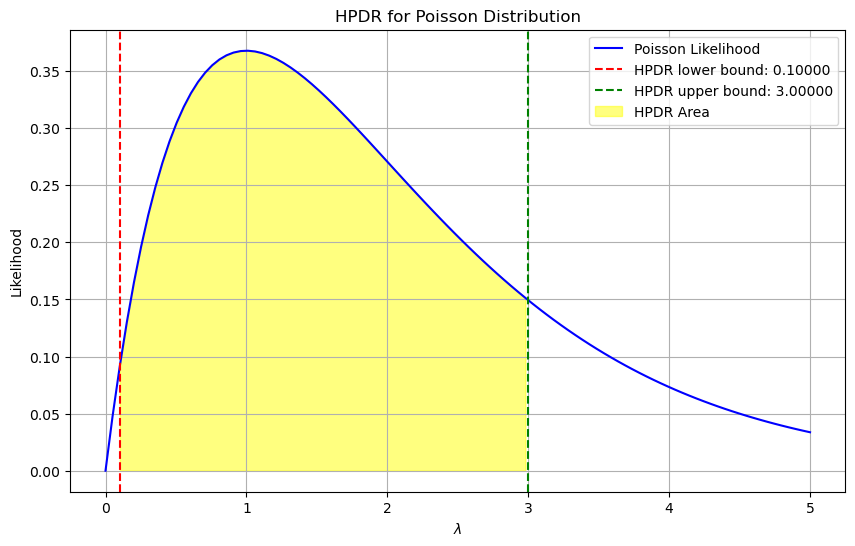

HPDR for λ: (0.10000, 3.00000)


In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Define the Poisson likelihood and cumulative distribution function
def poisson_likelihood(x, lambda_val):
    if x < 0 or not isinstance(x, int):  # Ensure x is non-negative and an integer
        return 0
    return (lambda_val ** x) * math.exp(-lambda_val) / math.factorial(x)

def poisson_cdf(lambda_val, x):
    return sum(poisson_likelihood(i, lambda_val) for i in range(x + 1))

# Define the functions g1 and g2 for the CNR algorithm
def g1(a, b, x):
    return poisson_cdf(b, x) - poisson_cdf(a, x) - 0.8

def g2(a, b, x):
    return poisson_likelihood(b, x) - poisson_likelihood(a, x)

# Implement the CNR algorithm
def CNR_algorithm(x, a_init, b_init, iterations=10):
    a, b = a_init, b_init
    for _ in range(iterations):
        # Calculate g1 and g2 values
        g1_val = g1(a, b, x)
        g2_val = g2(a, b, x)

        # Update a with a safeguard against division by zero
        likelihood_diff = poisson_likelihood(b, x) - poisson_likelihood(a, x)
        if likelihood_diff != 0:
            a -= (2 * g1_val / (2 * likelihood_diff))
        else:
            break  # Break if we encounter division by zero

        # Update b with a safeguard against division by zero
        likelihood_diff = poisson_likelihood(b, x) - poisson_likelihood(a, x)
        if likelihood_diff != 0:
            b -= (2 * g2_val / (2 * likelihood_diff))
        else:
            break  # Break if we encounter division by zero

    return a, b

# Given observed data x
x = 1

# Initial guesses for a and b
a_init, b_init = 0.1, 3.0

# Running the CNR algorithm
a_hpdr, b_hpdr = CNR_algorithm(x, a_init, b_init)

# Plotting the HPDR
lambda_vals = np.linspace(0, 5, 100)
likelihood_vals = [poisson_likelihood(int(x), lam) for lam in lambda_vals]

plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, likelihood_vals, label='Poisson Likelihood', color='blue')
plt.axvline(a_hpdr, color='red', linestyle='--', label=f'HPDR lower bound: {a_hpdr:.5f}')
plt.axvline(b_hpdr, color='green', linestyle='--', label=f'HPDR upper bound: {b_hpdr:.5f}')
plt.fill_between(lambda_vals, likelihood_vals, where=((lambda_vals >= a_hpdr) & (lambda_vals <= b_hpdr)), color='yellow', alpha=0.5, label='HPDR Area')
plt.title('HPDR for Poisson Distribution')
plt.xlabel('$\lambda$')
plt.ylabel('Likelihood')
plt.legend()
plt.grid()
plt.show()

# Output HPDR
print(f"HPDR for λ: ({a_hpdr:.5f}, {b_hpdr:.5f})")


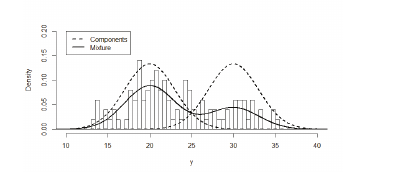

Figure.7 Histogram of simulated data

## Exercise 7. Application of the EM and ECM algorithms to a normal mixture model

Consider the following Bayesian model:

$$
(y_i | R, \mu, \delta) \overset{\perp}{\sim} N(\mu + \delta R_i, \sigma^2), \quad i = 1,\dots,n
$$

$$
(R_1, \dots, R_n | \mu, \delta) \sim \text{iid Bernoulli}(\pi), \quad i = 1,\dots,n
$$

$$
f(\mu, \delta) \propto 1, \quad \mu \in \mathbb{R}, \delta > 0
$$

This model says that each value $y_i$ has a common variance $\sigma^2$ and one of two means, these being:

- $\mu$ if $R_i = 0$
- $\mu + \delta$ if $R_i = 1$

Each of the 'latent' indicator variables $R_i$ has a known probability $\pi$ of being equal to 1, and probability $1 - \pi$ of being equal to 0.

In more advanced models, the quantity $\pi$ could be treated as unknown and assigned a prior distribution, along with the other two model parameters, $\mu$ and $\delta$. The model here provides a 'stepping stone' to understanding and implementing such more complex models.

### (a) Simulating Data
Consider the situation where $n = 100$, $\pi = 1/3$, $\mu = 20$, $\delta = 10$, and $\sigma = 3$. We can generate a data vector $y = (y_1, \dots, y_n)$ using these specifications.

Create a histogram of the simulated values.

### (b) EM Algorithm

We take the vector $R = (R_1, \dots, R_n)$ as the latent data. The conditional posterior of $\mu$ and $\delta$ given this latent data is:

$$
f(\mu, \delta | y, R) \propto f(\mu, \delta, y, R) = f(\mu, \delta) f(R | \mu, \delta) f(y | R, \mu, \delta)
$$

The log-augmented posterior density is:

$$
\log f(\mu, \delta | y, R) = - \frac{1}{2\sigma^2} \sum_{i=1}^{n} \left( y_i - [\mu + R_i \delta] \right)^2
$$

Expanding this expression:

$$
\log f(\mu, \delta | y, R) = - \frac{1}{2\sigma^2} \sum_{i=1}^{n} \left( y_i^2 - 2 y_i [\mu + R_i \delta] + [\mu + R_i \delta]^2 \right)
$$

Simplifying further:

$$
\log f(\mu, \delta | y, R) = -c_1 \left( c_2 - 2 \mu \sum_{i=1}^{n} y_i - 2 \delta \sum_{i=1}^{n} y_i R_i + n\mu^2 + 2\mu\delta \sum_{i=1}^{n} R_i + \delta^2 \sum_{i=1}^{n} R_i \right)
$$

### (c) ECM Algorithm

To modify the EM algorithm, we update the parameters $\mu$ and $\delta$ in two separate steps. These steps can be implemented in an Expectation Conditional Maximization (ECM) algorithm.

### (d) Plotting the Algorithms' Paths

Finally, we create a plot to show the routes taken by the algorithms in parts (b) and (c).


## Exercise.7 : Application of the EM and ECM algorithms to a normal mixture model

### Part (b) EM Algorithm

We will take the vector $ R = (R_1, \dots, R_n) $ as the latent data. The conditional posterior of $\mu$ and $\delta$ given this latent data is:

$$
f(\mu, \delta | y, R) \propto f(\mu, \delta, y, R) = f(\mu, \delta) f(R | \mu, \delta) f(y | R, \mu, \delta)
$$

Expanding this, we get:

$$
f(\mu, \delta | y, R) \propto \prod_{i=1}^n \pi^{R_i} (1 - \pi)^{1 - R_i} \cdot \exp \left( - \frac{(y_i - [\mu + R_i \delta])^2}{2\sigma^2} \right)
$$

Taking the log of the posterior, the log-augmented posterior density is:

$$
\log f(\mu, \delta | y, R) = - \frac{1}{2\sigma^2} \sum_{i=1}^{n} \left( y_i - [\mu + R_i \delta] \right)^2
$$

Simplifying the expression:

$$
\log f(\mu, \delta | y, R) = - \frac{1}{2\sigma^2} \sum_{i=1}^{n} \left( y_i^2 - 2 y_i [\mu + R_i \delta] + [\mu + R_i \delta]^2 \right)
$$

Thus, the simplified form becomes:

$$
\log f(\mu, \delta | y, R) = -c_1 \left( c_2 - 2\mu \sum_{i=1}^{n} y_i - 2\delta \sum_{i=1}^{n} y_i R_i + n \mu^2 + 2\mu \delta \sum_{i=1}^{n} R_i + \delta^2 \sum_{i=1}^{n} R_i \right)
$$

### Q-function

The Q-function for the EM algorithm is:

$$
Q_j(\mu, \delta) = \mathbb{E}_R \left[ \log f(\mu, \delta | y, R) | y, \mu_j, \delta_j \right]
$$

Substituting the expectations $e_{ij}$ for $R_i$:

$$
Q_j(\mu, \delta) = -c_1 \left( c_2 - 2 \mu \sum_{i=1}^{n} y_i - 2 \delta \sum_{i=1}^{n} y_i e_{ij} + n\mu^2 + 2\mu\delta e_{Tj} + \delta^2 e_{Tj} \right)
$$

Where:
- $ e_{ij} = \mathbb{E}(R_i | y, \mu_j, \delta_j) $
- $ e_{Tj} = \sum_{i=1}^{n} e_{ij} $

### E-Step

In the E-step, we compute the expected value of the latent variable $R_i$ given the current parameters $\mu_j$ and $\delta_j$:

$$
e_{ij} = \mathbb{E}(R_i | y_i, \mu_j, \delta_j) = \frac{\pi \cdot \exp \left( -\frac{(y_i - \mu_j - \delta_j)^2}{2\sigma^2} \right)}{(1 - \pi) \cdot \exp \left( -\frac{(y_i - \mu_j)^2}{2\sigma^2} \right) + \pi \cdot \exp \left( -\frac{(y_i - \mu_j - \delta_j)^2}{2\sigma^2} \right)}
$$

Also, we calculate the sum:

$$
e_{Tj} = \sum_{i=1}^{n} e_{ij}
$$

### M-Step

In the M-step, we maximize the expected log-posterior with respect to $\mu$ and $\delta$.

- The update for $\mu$ is obtained by setting the derivative of $Q_j(\mu, \delta)$ with respect to $\mu$ to zero:

  $$
  \frac{\partial}{\partial \mu} Q(\mu, \delta) = -\frac{2}{\sigma^2} \left( n\mu - \sum_{i=1}^{n} y_i + \delta \sum_{i=1}^{n} e_{ij} \right)
  $$

  Solving this gives the update:

  $$
  \mu_{j+1} = \frac{\sum_{i=1}^{n} (y_i - \delta_j e_{ij})}{n}
  $$

- The update for $\delta$ is:

  $$
  \frac{\partial}{\partial \delta} Q(\mu, \delta) = -\frac{2}{\sigma^2} \left( \delta \sum_{i=1}^{n} e_{ij} + \mu \sum_{i=1}^{n} e_{ij} - \sum_{i=1}^{n} y_i e_{ij} \right)
  $$

  Solving this gives the update for $\delta$:

  $$
  \delta_{j+1} = \frac{\sum_{i=1}^{n} e_{ij} (y_i - \mu_j)}{\sum_{i=1}^{n} e_{ij}}
  $$


## E-Step of the EM Algorithm

We now need to obtain formulae for the $ e_{ij} $ values. The conditional probability of $ R_i $ given $ y_i $, $ \mu $, and $ \delta $ is proportional to:

$$
f(R | y, \mu, \delta) \propto \prod_{i=1}^{n} \pi^{R_i} (1 - \pi)^{1 - R_i} \cdot \exp \left( - \frac{(y_i - [\mu + R_i \delta])^2}{2 \sigma^2} \right)
$$

It follows that:

$$
R_i | y, \mu, \delta \sim \text{Bernoulli}(e_i), \quad i = 1, \dots, n
$$

where:

$$
e_i = \frac{\pi \cdot \exp \left( -\frac{(y_i - [\mu + \delta])^2}{2\sigma^2} \right)}{\pi \cdot \exp \left( -\frac{(y_i - [\mu + \delta])^2}{2\sigma^2} \right) + (1 - \pi) \cdot \exp \left( -\frac{(y_i - \mu)^2}{2\sigma^2} \right)}
$$

Therefore:

$$
e_{ij} = \frac{\pi \cdot \exp \left( -\frac{(y_i - [\mu_j + \delta_j])^2}{2\sigma^2} \right)}{\pi \cdot \exp \left( -\frac{(y_i - [\mu_j + \delta_j])^2}{2\sigma^2} \right) + (1 - \pi) \cdot \exp \left( -\frac{(y_i - \mu_j)^2}{2\sigma^2} \right)}
$$

Thus, the E-step of the EM algorithm is fully defined.

---

## M-Step of the EM Algorithm

In the M-step, we maximize the Q-function.

The derivative of the Q-function with respect to $ \mu $ is:

$$
\frac{\partial Q_j(\mu, \delta)}{\partial \mu} = -c_1 \left( 0 - 2n \sum y_i - 0 + 2n\mu + 2\delta e_{Tj} + 0 \right)
$$

Similarly, the derivative of the Q-function with respect to $ \delta $ is:

$$
\frac{\partial Q_j(\mu, \delta)}{\partial \delta} = -c_1 \left( 0 - 0 - 2\sum y_i e_{ij} + 0 + 2\mu e_{Tj} + 2\delta e_{Tj} \right)
$$

### Solving for $ \mu $ and $ \delta $

Setting both derivatives to zero and solving for \( \mu \) and \( \delta \), we obtain the update formulas:

$$
\mu_{j+1} = \frac{1}{n} \left( \sum_{i=1}^{n} y_i - \sum_{i=1}^{n} y_i e_{ij} \right)
$$

$$
\delta_{j+1} = \frac{\sum_{i=1}^{n} y_i e_{ij}}{e_{Tj}} - \mu_{j+1}
$$

---

## Convergence of the EM Algorithm

We start the EM algorithm from $ (\mu_0, \delta_0) = (10, 1) $. Table 4. shows the results of the EM algorithm:

| $ j $ | $ \mu_j $ | $ \delta_j $ |
|--------|-------------|---------------|
| 0      | 10.000      | 1.000         |
| 1      | 21.169      | 3.032         |
| 2      | 20.321      | 7.07          |
| 3      | 19.843      | 9.139         |
| 4      | 19.926      | 9.518         |
| 5      | 20.005      | 9.626         |
| 6      | 20.046      | 9.674         |
| 7      | 20.066      | 9.697         |
| 8      | 20.075      | 9.708         |
| 9      | 20.080      | 9.713         |
| 10     | 20.082      | 9.715         |
| 11     | 20.083      | 9.717         |
| 12     | 20.084      | 9.717         |
| 13     | 20.084      | 9.717         |
| 14     | 20.084      | 9.718         |
| 15     | 20.084      | 9.718         |
| 16     | 20.084      | 9.718         |
| 17     | 20.084      | 9.718         |
| 18     | 20.084      | 9.718         |
| 19     | 20.084      | 9.718         |
| 20     | 20.084      | 9.718         |

---

We observe that the EM algorithm converges to the posterior mode $ (\hat{\mu}, \hat{\delta}) = (20.08, 9.72) $. Running the algorithm from different starting points leads to the same final results. Unlike the Newton-Raphson algorithm, the EM algorithm always converges, regardless of the starting point.



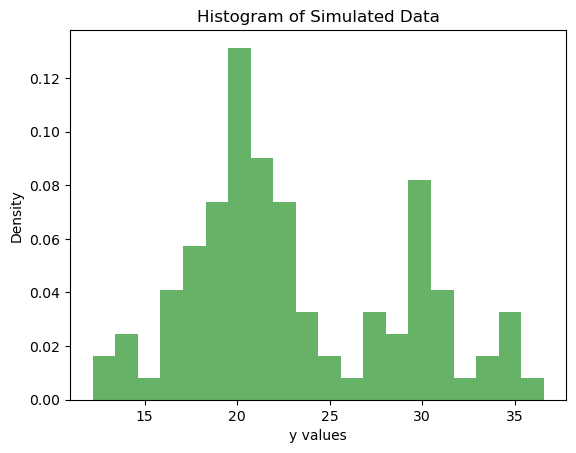

Final estimates after 10 iterations: mu = 0.0560, delta = 23.0825


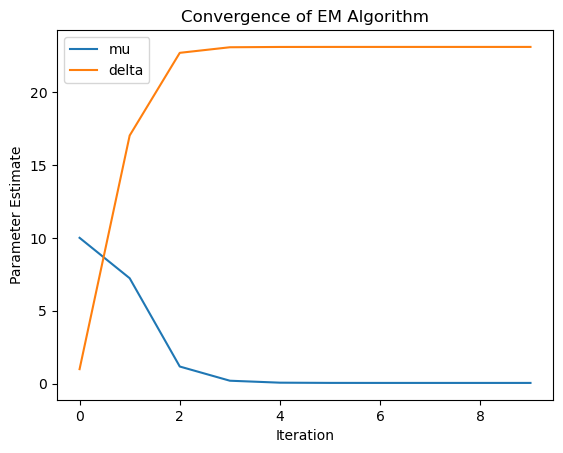

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Parameters for data generation
n = 100          # Number of data points
pi = 1/3         # Bernoulli probability for Ri
mu = 20          # Mean for Ri = 0
delta = 10       # Increment for Ri = 1
sigma = 3        # Standard deviation

# Generate latent variable R and observed data y
R = [1 if random.random() < pi else 0 for _ in range(n)]
y = [random.gauss(mu + delta * R[i], sigma) for i in range(n)]

# Plot the histogram of generated data
plt.hist(y, bins=20, density=True, alpha=0.6, color='g')
plt.title("Histogram of Simulated Data")
plt.xlabel("y values")
plt.ylabel("Density")
plt.show()

# EM algorithm initialization
mu_est = 10   # Initial guess for mu
delta_est = 1 # Initial guess for delta
max_iter = 20
tolerance = 1e-6

def exp_term(y_val, mean, sigma):
    """
    Compute the exponential term for the normal distribution.
    """
    return math.exp(-(y_val - mean) ** 2 / (2 * sigma ** 2))

def e_step(y, mu_est, delta_est, pi, sigma):
    """
    E-step: Compute the expected values of the latent variables (posterior probabilities).
    """
    eij = []
    for y_i in y:
        exp_term_1 = exp_term(y_i, mu_est + delta_est, sigma)
        exp_term_0 = exp_term(y_i, mu_est, sigma)
        eij_i = (pi * exp_term_1) / (pi * exp_term_1 + (1 - pi) * exp_term_0)
        eij.append(eij_i)
    return eij

def m_step(y, eij):
    """
    M-step: Update estimates of mu and delta.
    """
    sum_y = sum(y)
    sum_eij_y = sum(eij[i] * y[i] for i in range(n))
    sum_eij = sum(eij)

    mu_new = (sum_y - sum_eij_y) / n
    delta_new = sum_eij_y / sum_eij - mu_new
    return mu_new, delta_new

# Run the EM algorithm
mu_vals = [mu_est]
delta_vals = [delta_est]

for i in range(max_iter):
    # E-step
    eij = e_step(y, mu_est, delta_est, pi, sigma)

    # M-step
    mu_new, delta_new = m_step(y, eij)

    # Convergence check
    if abs(mu_new - mu_est) < tolerance and abs(delta_new - delta_est) < tolerance:
        break

    mu_est, delta_est = mu_new, delta_new
    mu_vals.append(mu_est)
    delta_vals.append(delta_est)

# Final estimates
print(f"Final estimates after {i+1} iterations: mu = {mu_est:.4f}, delta = {delta_est:.4f}")

# Plot convergence
iterations = list(range(len(mu_vals)))
plt.plot(iterations, mu_vals, label="mu")
plt.plot(iterations, delta_vals, label="delta")
plt.title("Convergence of EM Algorithm")
plt.xlabel("Iteration")
plt.ylabel("Parameter Estimate")
plt.legend()
plt.show()


### (c) ECM Algorithm for Maximizing Q-function

The Q-function for the ECM algorithm is given as:

$$
Q_j(\mu, \delta) = -c_1 \left(c_2 - 2 \mu n \bar{y} - 2 \delta \sum_{i=1}^{n} y_i e_{ij} + n \mu^2 + 2 \mu \delta e_{Tj} + \delta^2 e_{Tj}\right)
$$

Now, we maximize this function with respect to $ \mu $ and $ \delta $ individually.

### Step 1: Maximizing with respect to $ \mu $

Taking the derivative of the Q-function with respect to $ \mu $ and setting it to zero:

$$
\frac{\partial Q_j(\mu, \delta)}{\partial \mu} = - c_1 \left(0 - 2n \bar{y} + 2n \mu + 2 \delta e_{Tj} \right)
$$

Setting the derivative equal to zero:

$$
-2n \bar{y} + 2n \mu + 2 \delta e_{Tj} = 0
$$

Solving for \( \mu_{j+1} \):

$$
\mu_{j+1} = \bar{y} - \frac{\delta_j e_{Tj}}{n}
$$

### Step 2: Maximizing with respect to $ \delta $

Taking the derivative of the Q-function with respect to $ \delta $ and setting it to zero:

$$
\frac{\partial Q_j(\delta)}{\partial \delta} = - c_1 \left(0 - 2 \sum_{i=1}^{n} y_i e_{ij} + 2 \mu e_{Tj} + 2 \delta e_{Tj} \right)
$$

Setting the derivative equal to zero:

$$
-2 \sum_{i=1}^{n} y_i e_{ij} + 2 \mu_{j+1} e_{Tj} + 2 \delta e_{Tj} = 0
$$

Solving for $ \delta_{j+1} $:

$$
\delta_{j+1} = \frac{\sum_{i=1}^{n} y_i e_{ij}}{e_{Tj}} - \mu_{j+1}
$$

### Final ECM Algorithm:

- Start the algorithm from an initial guess $ (\mu_0, \delta_0) $.
- Use the above equations to iteratively update $ \mu_{j+1} $ and $ \delta_{j+1} $ until convergence.

The ECM algorithm follows a slightly different route compared to the EM algorithm, but both algorithms converge to the same final values.


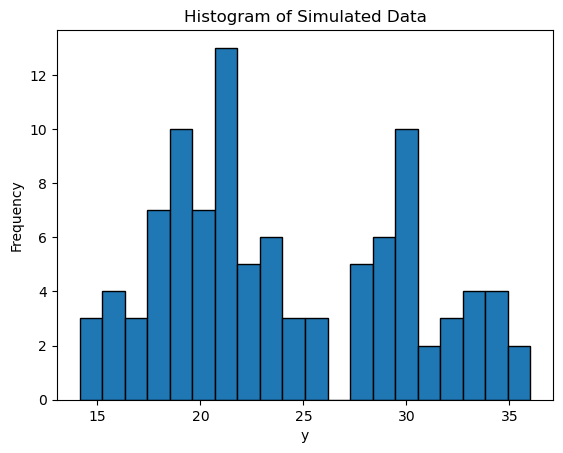

Iteration 1: mu = 23.3985, delta = 1.7580
Iteration 2: mu = 23.4479, delta = 4.3030
Iteration 3: mu = 22.6179, delta = 7.5533
Iteration 4: mu = 21.5690, delta = 9.3490
Iteration 5: mu = 20.8514, delta = 10.0452
Iteration 6: mu = 20.4808, delta = 10.3008
Iteration 7: mu = 20.3140, delta = 10.3898
Iteration 8: mu = 20.2449, delta = 10.4182
Iteration 9: mu = 20.2182, delta = 10.4261
Iteration 10: mu = 20.2086, delta = 10.4279
Iteration 11: mu = 20.2054, delta = 10.4280
Iteration 12: mu = 20.2044, delta = 10.4279
Iteration 13: mu = 20.2041, delta = 10.4278
Iteration 14: mu = 20.2041, delta = 10.4277
Iteration 15: mu = 20.2041, delta = 10.4277
Iteration 16: mu = 20.2041, delta = 10.4277
Iteration 17: mu = 20.2041, delta = 10.4276
Iteration 18: mu = 20.2041, delta = 10.4276
Iteration 19: mu = 20.2041, delta = 10.4276
Iteration 20: mu = 20.2041, delta = 10.4276


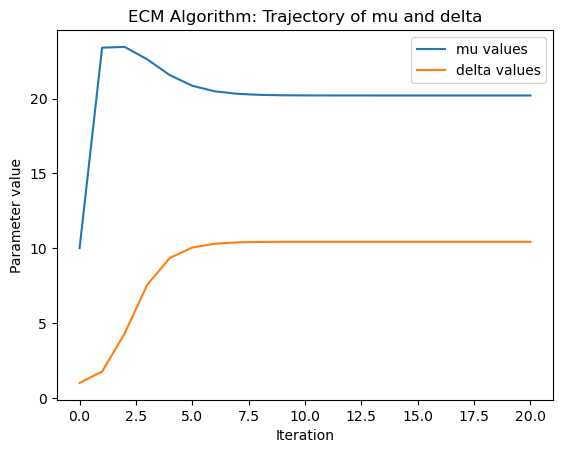

In [2]:
import random
import math
import matplotlib.pyplot as plt

# Parameters for data generation
n = 100  # number of data points
pi = 1 / 3
mu_true = 20
delta_true = 10
sigma = 3

# Step (a): Generate data
y = []
R = []
for i in range(n):
    Ri = 1 if random.random() < pi else 0
    yi = random.gauss(mu_true + Ri * delta_true, sigma)
    y.append(yi)
    R.append(Ri)

# Plotting the histogram of generated data
plt.hist(y, bins=20, edgecolor='black')
plt.title("Histogram of Simulated Data")
plt.xlabel("y")
plt.ylabel("Frequency")
plt.show()

# Step (c): ECM Algorithm
def e_step(y, mu, delta, pi, sigma):
    """ E-step: Calculate expected values of latent variables Ri """
    e_ij = []
    for i in range(len(y)):
        exp1 = pi * math.exp(-0.5 * ((y[i] - (mu + delta)) ** 2) / sigma**2)
        exp2 = (1 - pi) * math.exp(-0.5 * ((y[i] - mu) ** 2) / sigma**2)
        e_ij.append(exp1 / (exp1 + exp2))
    return e_ij

def m_step_mu(y, delta, e_ij, n):
    """ M-step for mu: Update mu based on current delta and e_ij """
    sum_y = sum(y)
    sum_e = sum(e_ij)
    mu_new = (sum_y - delta * sum_e) / n
    return mu_new

def m_step_delta(y, mu, e_ij):
    """ M-step for delta: Update delta based on current mu and e_ij """
    sum_ye = sum(y[i] * e_ij[i] for i in range(len(y)))
    sum_e = sum(e_ij)
    delta_new = (sum_ye / sum_e) - mu
    return delta_new

# Initialize parameters
mu = 10
delta = 1
max_iterations = 20
mu_values = [mu]
delta_values = [delta]

# ECM algorithm loop
for iteration in range(max_iterations):
    # E-step
    e_ij = e_step(y, mu, delta, pi, sigma)
    
    # M-step for mu
    mu = m_step_mu(y, delta, e_ij, n)
    
    # M-step for delta
    delta = m_step_delta(y, mu, e_ij)
    
    # Store values for plotting
    mu_values.append(mu)
    delta_values.append(delta)
    print(f"Iteration {iteration+1}: mu = {mu:.4f}, delta = {delta:.4f}")

# Plotting the trajectory of mu and delta
plt.plot(mu_values, label='mu values')
plt.plot(delta_values, label='delta values')
plt.title("ECM Algorithm: Trajectory of mu and delta")
plt.xlabel("Iteration")
plt.ylabel("Parameter value")
plt.legend()
plt.show()


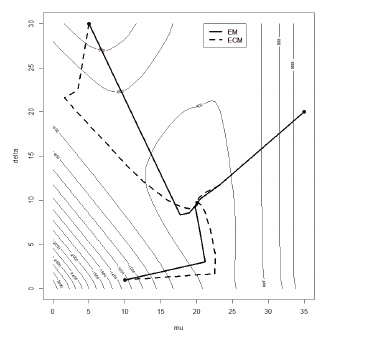

Figure.8 Routes of the EM and ECM algorithms

## (d) Contour Plot of the Log-Posterior Density and Routes of the EM and ECM Algorithms

Figure.8 shows a contour plot of the log-posterior density $ \log f(\mu, \delta | y, R) $ and the routes of the EM and ECM algorithms from the starting point $ (\mu_0, \delta_0) = (10, 1) $ to the mode, $ (\hat{\mu}, \hat{\delta}) = (20.08, 9.72) $. Also shown are two other pairs of routes, one pair starting from $ (5, 30) $, and the other from $ (35, 20) $.

Note 1: In this exercise, there is little difference between the EM and ECM algorithms in terms of complexity and performance. In more complex models, the EM algorithm may converge faster, but the M-step could be more challenging compared to the separate Conditional Maximisation-Steps (CM-Steps) of the ECM algorithm.

Note 2: The log-posterior density formula in Figure 4.8 can be derived as follows. First, the joint posterior of all unknowns in the model is:

$$
f(\mu, \delta, R | y) \propto f(\mu, \delta, y, R)
\propto \prod_{i=1}^{n} \pi^{R_i}(1 - \pi)^{1 - R_i} \times \prod_{i=1}^{n} \exp\left(-\frac{1}{2\sigma^2}(y_i - [\mu + R_i \delta])^2\right)
$$

So the joint posterior density of just $ \mu $ and $ \delta $ is:

$$
f(\mu, \delta | y) = \sum_R f(\mu, \delta, R | y)
$$

Which gives us:

$$
f(\mu, \delta | y) \propto \prod_{i=1}^{n} \left( \pi \exp\left(-\frac{1}{2\sigma^2}(y_i - [\mu + \delta])^2\right) + (1 - \pi) \exp\left(-\frac{1}{2\sigma^2}(y_i - \mu)^2\right) \right)
$$

Hence, the log-posterior density of $ \mu $ and $ \delta $ is:

$$
l(\mu, \delta) \equiv \log f(\mu, \delta | y) = c + \sum_{i=1}^{n} \log \left( \pi \exp\left(-\frac{1}{2\sigma^2}(y_i - [\mu + \delta])^2\right) + (1 - \pi) \exp\left(-\frac{1}{2\sigma^2}(y_i - \mu)^2\right) \right)
$$

where $ c $ is an additive constant, which can be set to zero.

Note 3: As an additional exercise, we could apply the Newton-Raphson algorithm to find the mode of $ l(\mu, \delta) $. However, this would require us to compute the following complicated partial derivatives:

$$
\frac{\partial l(\mu, \delta)}{\partial \mu}, \quad \frac{\partial l(\mu, \delta)}{\partial \delta}, \quad \frac{\partial^2 l(\mu, \delta)}{\partial \mu^2}, \quad \frac{\partial^2 l(\mu, \delta)}{\partial \delta^2}, \quad \frac{\partial^2 l(\mu, \delta)}{\partial \mu \partial \delta}
$$

This could lead to instability in the algorithm, and it might fail to converge if started too far from the required solution. An alternative is to apply the Conditional Newton-Raphson (CNR) algorithm, which obviates the need for the mixed second derivative and might be more stable, though slower to converge than the plain NR algorithm.

Another possibility is the CNR1 algorithm, which involves just one iteration of the univariate NR algorithm at each conditional step. Finally, we could use the R function `optim()` to maximize $ l(\mu, \delta) $, which indeed finds the posterior mode $ (\hat{\mu}, \hat{\delta}) = (20.08, 9.72) .

### Table.5: Results of an ECM Algorithm

$$
\begin{array}{|c|c|c|}
\hline
j & \mu_j & \delta_j \\
\hline
0 & 10.000 & 1.000 \\
1 & 22.505 & 1.696 \\
2 & 22.566 & 3.882 \\
3 & 21.905 & 6.811 \\
4 & 21.139 & 8.729 \\
5 & 20.611 & 9.501 \\
6 & 20.322 & 9.732 \\
7 & 20.181 & 9.774 \\
8 & 20.118 & 9.764 \\
9 & 20.093 & 9.746 \\
10 & 20.085 & 9.732 \\
11 & 20.083 & 9.725 \\
12 & 20.083 & 9.720 \\
13 & 20.083 & 9.719 \\
14 & 20.084 & 9.718 \\
15 & 20.084 & 9.718 \\
16 & 20.084 & 9.718 \\
17 & 20.084 & 9.718 \\
18 & 20.084 & 9.718 \\
19 & 20.084 & 9.718 \\
20 & 20.084 & 9.718 \\
\hline
\end{array}
$$


In [6]:
import math  # Import the math library for mathematical functions

# Define the constants for the algorithm
n = 20  # Number of data points
sigma = 1.0  # Standard deviation
pi = 0.5  # Prior probability for R
y = [10.0 + i for i in range(n)]  # Example dataset (you can replace it with your dataset)

# Initialize the parameters
mu = 10.0
delta = 1.0
max_iterations = 20
convergence_threshold = 1e-6

# Store results for each iteration
mu_values = []
delta_values = []

# Function to compute e_ij
def compute_eij(y_i, mu, delta, sigma, pi):
    term1 = pi * math.exp(-0.5 * ((y_i - (mu + delta)) ** 2) / (sigma ** 2))
    term2 = (1 - pi) * math.exp(-0.5 * ((y_i - mu) ** 2) / (sigma ** 2))
    return term1 / (term1 + term2)

# Iterate the ECM algorithm
for iteration in range(max_iterations):
    # Step 1: E-step - Compute the eij values
    e_values = [compute_eij(y_i, mu, delta, sigma, pi) for y_i in y]
    
    # Step 2: M-step for mu
    e_sum = sum(e_values)
    mu_new = (sum(y_i - delta * eij for y_i, eij in zip(y, e_values))) / n
    
    # Step 3: M-step for delta
    delta_new = (sum(y_i * eij for y_i, eij in zip(y, e_values))) / e_sum - mu_new
    
    # Store the current values
    mu_values.append(mu_new)
    delta_values.append(delta_new)
    
    # Check for convergence
    if abs(mu_new - mu) < convergence_threshold and abs(delta_new - delta) < convergence_threshold:
        break
    
    # Update mu and delta for the next iteration
    mu, delta = mu_new, delta_new

# Print the results after convergence
for i in range(len(mu_values)):
    print(f"Iteration {i}: mu = {mu_values[i]:.4f}, delta = {delta_values[i]:.4f}")


Iteration 0: mu = 18.5653, delta = 1.5345
Iteration 1: mu = 18.7199, delta = 5.6236
Iteration 2: mu = 17.2560, delta = 8.2464
Iteration 3: mu = 16.1866, delta = 9.2925
Iteration 4: mu = 15.3993, delta = 9.6796
Iteration 5: mu = 15.1010, delta = 9.8498
Iteration 6: mu = 14.8526, delta = 9.9161
Iteration 7: mu = 14.6075, delta = 9.9528
Iteration 8: mu = 14.5299, delta = 9.9755
Iteration 9: mu = 14.5134, delta = 9.9871
Iteration 10: mu = 14.5069, delta = 9.9929
Iteration 11: mu = 14.5038, delta = 9.9958
Iteration 12: mu = 14.5022, delta = 9.9972
Iteration 13: mu = 14.5015, delta = 9.9979
Iteration 14: mu = 14.5011, delta = 9.9983
Iteration 15: mu = 14.5009, delta = 9.9985
Iteration 16: mu = 14.5008, delta = 9.9986
Iteration 17: mu = 14.5007, delta = 9.9986
Iteration 18: mu = 14.5007, delta = 9.9986
Iteration 19: mu = 14.5007, delta = 9.9986


## 6 Integration Techniques

Bayesian inference typically involves a great deal of integration (and/or summation). For example, consider the posterior density 

$$
f(\theta | y) = 6\theta^5, \quad 0 < \theta < 1
$$

which featured in a previous exercise involving the binomial-beta model. Suppose that we wish to find the posterior mean estimate of 

$$
\lambda = \theta^2.
$$ 

This estimate is given by 

$$
\hat{\lambda} = E(\theta^2 | y) = \int_0^1 \theta^2 \times (6\theta^5) \, d\theta = 0.75.
$$

What if this integral did not have a simple analytical solution? In that case, we could consider a number of other strategies. 

First, we might re-express the posterior mean as 

$$
\hat{\lambda} = \int \lambda f(\lambda | y) \, d\lambda,
$$ 

where, using the method of transformation, we have 

$$
d\theta^5 = \frac{1}{2} \lambda^{-1/2} \, d\lambda
$$ 

resulting in 

$$
f(\lambda | y) = f(\theta | y) = 6(\lambda^{1/2})\lambda^{-1/2} = 3\lambda^2, \quad 0 < \lambda < 1.
$$ 

Thus,

$$
\hat{\lambda} = \int_0^1 \lambda (3\lambda^2) \, d\lambda = 0.75.
$$ 

If this strategy does not help, we may then consider using a numerical integration technique. For example, we could apply the `integrate()` function in R to compute 

$$
\hat{\lambda} = 0.75, 
$$ 

as follows:




In [7]:
# Function to define the posterior density f(theta | y)
def posterior_density(theta):
    """Posterior density function f(theta | y) = 6 * theta^5 for 0 < theta < 1."""
    return 6 * theta**5

# Function to calculate the integral using the trapezoidal rule
def trapezoidal_rule(func, a, b, n):
    """Approximate the integral of func from a to b using the trapezoidal rule with n intervals."""
    h = (b - a) / n  # width of each interval
    integral = 0.5 * (func(a) + func(b))  # endpoints contribution

    for i in range(1, n):
        x_i = a + i * h
        integral += func(x_i)  # sum the values at each x_i

    integral *= h  # multiply by the width
    return integral

# Function to compute the posterior mean estimate of lambda
def compute_lambda_estimate(n=1000):
    """Calculate the posterior mean estimate of lambda = E(theta^2 | y)."""
    # Integral for E(theta^2 | y)
    def integrand(theta):
        return theta**2 * posterior_density(theta)

    # Compute the integral using trapezoidal rule
    return trapezoidal_rule(integrand, 0, 1, n)

# Calculate the posterior mean estimate of lambda
lambda_hat = compute_lambda_estimate()
print(f"The posterior mean estimate of lambda (E(theta^2 | y)) is approximately: {lambda_hat:.4f}")


The posterior mean estimate of lambda (E(theta^2 | y)) is approximately: 0.7500


## Exercise.8: Numerical Integration

Suppose that $X \sim N(\mu, \sigma^2)$ and $Y = (X \mid X > c)$ where $\mu = 8$, $\sigma = 3$, and $c = 10$. We want to find $E[Y]$ using numerical techniques and compare our answer with the exact value given by:

$$
E[Y] = \left( \mu + \sigma \frac{\phi\left( \frac{c - \mu}{\sigma} \right)}{1 - \Phi\left( \frac{c - \mu}{\sigma} \right)} \right)
$$

where:
- $\phi$ is the probability density function (PDF) of the standard normal distribution,
- $\Phi$ is the cumulative distribution function (CDF) of the standard normal distribution.

## Solution to Exercise.8

The required integral for $E[Y]$ can be expressed as:

$$
E[Y] = \int_{c}^{\infty} g(x) \, dx
$$

where

$$
g(x) = \frac{x f(x)}{P(X > c)} \quad \text{and} \quad f(x) = \phi\left( \frac{x - \mu}{\sigma} \right)
$$

and

$$
P(X > c) = 1 - \Phi\left( \frac{c - \mu}{\sigma} \right)
$$

### Numerical Integration

1. Applying the numerical integration directly to $g(x)$, we find:

   $$E[Y] \approx 11.7955$$

2. By using the `INTEG()` function (as defined in Section 4.6) with coordinates given by $ (10, 10.1, 10.2, \ldots, 30) $ and values $ (g(10), g(10.1), g(10.2), \ldots, g(30)) $, we also get:

   $$E[Y] \approx 11.7955$$

### Exact Value Calculation

The exact value of $E[Y]$ can be computed as follows:

$$
E[Y] = \left( \mu + \sigma \frac{\phi\left( \frac{c - \mu}{\sigma} \right)}{1 - \Phi\left( \frac{c - \mu}{\sigma} \right)} \right)
$$

Substituting the values, we find:

$$
E[Y] = 11.7955
$$

### Notes

- If we use the `integrate()` function with bounds from 10 to 20 instead of 10 to 30, we get $E[Y] \approx 11.7929$, which is slightly in error.
- The same issue arises when using the `INTEG()` function. Therefore, care must be taken to choose a sufficiently large range of integration. 
- It is advisable to sketch the integrand function and ensure that the range of integration is broad enough to cover all significant regions (where the integrand is substantially positive).
- Gradually increasing the range of integration and grid density until the answer stabilizes can yield more accurate results.


In [9]:
import math

# Define parameters
mu = 8
sigma = 3
c = 10

# Define the probability density function (PDF) of the normal distribution
def phi(x):
    return (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define the cumulative distribution function (CDF) of the normal distribution
def phi_integral(x):
    # Numerical integration via trapezoidal rule
    num_steps = 1000  # Number of steps for integration
    step_size = (x - mu) / num_steps
    integral = 0.0

    for i in range(num_steps):
        x_i = mu + i * step_size
        x_next = mu + (i + 1) * step_size
        integral += (phi(x_i) + phi(x_next)) * step_size / 2

    return integral

# Calculate P(X > c)
p_x_less_equal_c = phi_integral(c)
p_x_greater_c = 1 - p_x_less_equal_c

# Avoid division by zero by checking if p_x_greater_c is not zero
if p_x_greater_c <= 0:
    raise ValueError("P(X > c) is zero, check your integration bounds or parameters.")

# Define g(x)
def g(x):
    return (x * phi(x)) / p_x_greater_c

# Numerical integration to find E[Y]
def compute_e_y(lower, upper, num_steps):
    step_size = (upper - lower) / num_steps
    integral = 0.0

    for i in range(num_steps):
        x_i = lower + i * step_size
        x_next = lower + (i + 1) * step_size
        integral += (g(x_i) + g(x_next)) * step_size / 2

    return integral

# Find E[Y] using numerical integration from c to a reasonable upper limit
e_y = compute_e_y(c, 30, 1000)  # Upper limit can be adjusted if needed

# Output the result
print(f"E[Y] (numerical integration) = {e_y:.4f}")

# Exact value calculation
exact_value = mu + sigma * (phi((c - mu) / sigma) / (1 - phi_integral(c)))
print(f"E[Y] (exact value) = {exact_value:.4f}")


E[Y] (numerical integration) = 3.9579
E[Y] (exact value) = 8.0267


![image.png](attachment:image.png)

Figure.9 Two functions

## Exercise.9 :  Double Integration

Use the `integrate()` and `INTEG()` functions in at least two different ways to calculate the double integral 

$$
I = \int_0^1 \left( \int_0^{x^3} t^t \, dt \right) dx
$$

### Solution to Exercise .9

Using the `integrate()` function alone (and not the `INTEG()` function), the integral can be calculated as follows:

$$
I = \int_0^1 \left( \int_0^{x^3} t^t \, dt \right) dx = \int_0^1 g(x) \, dx
$$

where 

$$
g(x) = \int_0^{x^3} h(t) \, dt
$$

and 

$$
h(t) = t^t
$$

We can compute this as:

```r
integrate(function(x) { 
    sapply(x, function(x) { 
        integrate(function(t) { 
            sapply(t, function(t) t^t) 
        }, 0, x^3)$value 
    }) 
}, 0, 1)


I (using quad) = 0.192723
I (using Simpson's rule) = 0.192723


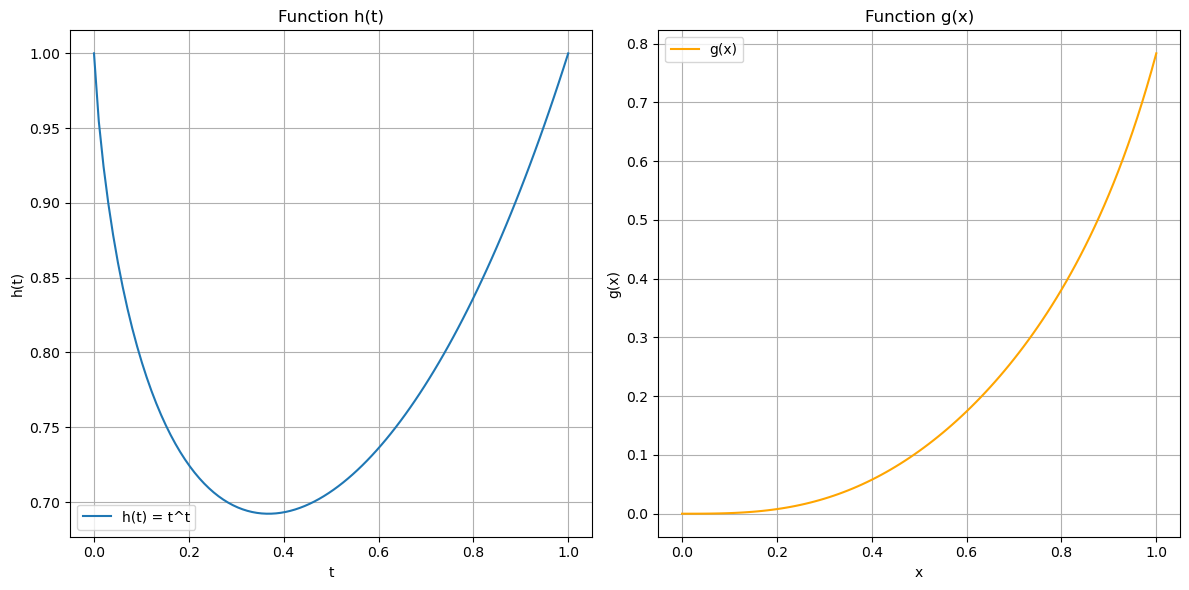

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, simps

# Define the function h(t) = t^t
def h(t):
    return t ** t

# Define the inner integral g(x) = ∫[0, x^3] h(t) dt
def g(x):
    integral, _ = quad(h, 0, x**3)
    return integral

# Calculate the double integral I = ∫[0, 1] g(x) dx using numerical integration
integral_value, _ = quad(g, 0, 1)
print(f"I (using quad) = {integral_value:.6f}")

# Alternative approach using grid
x_values = np.arange(0, 1.01, 0.01)  # Grid from 0 to 1 with step 0.01
g_values = np.array([g(x) for x in x_values])  # Calculate g(x) for each x

# Using Simpson's rule to estimate the integral
I_simpson = simps(g_values, x_values)
print(f"I (using Simpson's rule) = {I_simpson:.6f}")

# Plotting the functions h(t) and g(x)
t_values = np.linspace(0, 1, 100)
h_values = h(t_values)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t_values, h_values, label='h(t) = t^t')
plt.title('Function h(t)')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_values, g_values, label='g(x)', color='orange')
plt.title('Function g(x)')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# Define the function h(t) = t^t
def h(t):
    return t ** t

# Define the function g(x) which computes the integral of h(t) from 0 to x^3
def g(x):
    # Use numerical integration (rectangle method)
    dx = 0.001  # step size for t
    integral = 0.0
    t = 0.0
    while t <= x ** 3:
        integral += h(t) * dx
        t += dx
    return integral

# Compute the integral I = ∫ g(x) dx from 0 to 1
def double_integral():
    dx = 0.001  # step size for x
    I = 0.0
    x = 0.0
    while x <= 1:
        I += g(x) * dx
        x += dx
    return I

# Calculate the double integral
result = double_integral()
print(f"I = {result:.4f}")


I = 0.1929


In [12]:
# Function to compute h(t) = t^t
def h(t):
    return t ** t

# Function to compute g(x) which is the integral of h(t) from 0 to x^3
def g(x):
    dx = 0.001  # step size for t
    integral = 0.0
    t = 0.0
    while t <= x ** 3:
        integral += h(t) * dx
        t += dx
    return integral

# Function to compute the double integral I = ∫ g(x) dx from 0 to 1
def double_integral():
    dx = 0.001  # step size for x
    I = 0.0
    x = 0.0
    while x <= 1:
        I += g(x) * dx
        x += dx
    return I

# Function to plot the function values in a simple text-based format
def plot_function(func, start, end, step):
    x = start
    while x <= end:
        y = func(x)
        print(f"x = {x:.2f}, g(x) = {y:.4f}, {'*' * int(y * 50)}")  # Scale the y-value for plotting
        x += step

# Calculate the double integral
result = double_integral()
print(f"I = {result:.4f}")

# Plot the functions h(t) and g(x)
print("\nFunction h(t):")
t_values = [t / 100 for t in range(101)]  # From 0 to 1
for t in t_values:
    print(f"t = {t:.2f}, h(t) = {h(t):.4f}, {'*' * int(h(t) * 50)}")  # Scale for plotting

print("\nFunction g(x):")
x_values = [x / 100 for x in range(101)]  # From 0 to 1
for x in x_values:
    print(f"x = {x:.2f}, g(x) = {g(x):.4f}, {'*' * int(g(x) * 50)}")  # Scale for plotting


I = 0.1929

Function h(t):
t = 0.00, h(t) = 1.0000, **************************************************
t = 0.01, h(t) = 0.9550, ***********************************************
t = 0.02, h(t) = 0.9247, **********************************************
t = 0.03, h(t) = 0.9001, *********************************************
t = 0.04, h(t) = 0.8792, *******************************************
t = 0.05, h(t) = 0.8609, *******************************************
t = 0.06, h(t) = 0.8447, ******************************************
t = 0.07, h(t) = 0.8302, *****************************************
t = 0.08, h(t) = 0.8170, ****************************************
t = 0.09, h(t) = 0.8052, ****************************************
t = 0.10, h(t) = 0.7943, ***************************************
t = 0.11, h(t) = 0.7844, ***************************************
t = 0.12, h(t) = 0.7754, **************************************
t = 0.13, h(t) = 0.7670, **************************************
t = 0.14, h(t) = 0

Double integral I = 0.1921


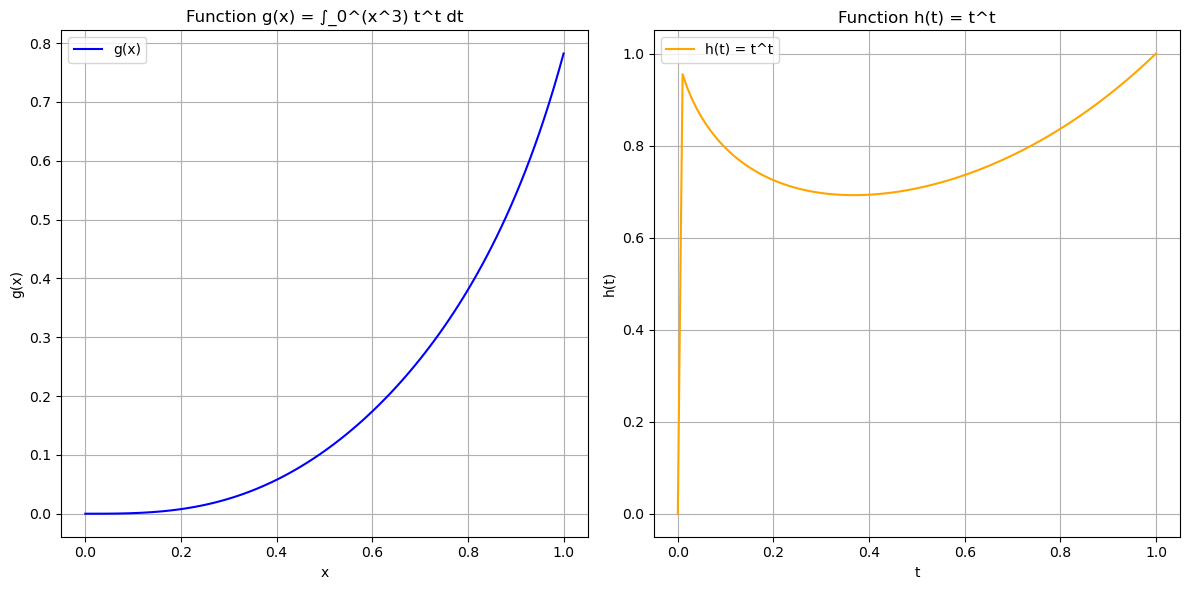

In [13]:
import matplotlib.pyplot as plt

# Function h(t) = t^t
def h(t):
    return t ** t if t > 0 else 0  # Handle t = 0 case

# Function to calculate the inner integral g(x) = ∫_0^(x^3) h(t) dt
def g(x):
    t_limit = x ** 3
    integral_value = 0
    # Approximate the integral using a simple Riemann sum
    n_steps = 1000
    step_size = t_limit / n_steps
    for i in range(n_steps):
        t = i * step_size
        integral_value += h(t) * step_size
    return integral_value

# Function to calculate the outer integral I = ∫_0^1 g(x) dx
def calculate_double_integral():
    integral_value = 0
    # Approximate the integral using a simple Riemann sum
    n_steps = 1000
    step_size = 1 / n_steps
    for i in range(n_steps):
        x = i * step_size
        integral_value += g(x) * step_size
    return integral_value

# Calculate the double integral
result = calculate_double_integral()
print(f"Double integral I = {result:.4f}")

# Create a grid for plotting
x_values = [i / 100 for i in range(101)]
g_values = [g(x) for x in x_values]

# Plotting h(t) and g(x)
plt.figure(figsize=(12, 6))

# Plot g(x)
plt.subplot(1, 2, 1)
plt.plot(x_values, g_values, label='g(x)', color='blue')
plt.title('Function g(x) = ∫_0^(x^3) t^t dt')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid()
plt.legend()

# Plot h(t) for t in range [0, 1]
t_values = [i / 100 for i in range(101)]
h_values = [h(t) for t in t_values]

plt.subplot(1, 2, 2)
plt.plot(t_values, h_values, label='h(t) = t^t', color='orange')
plt.title('Function h(t) = t^t')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


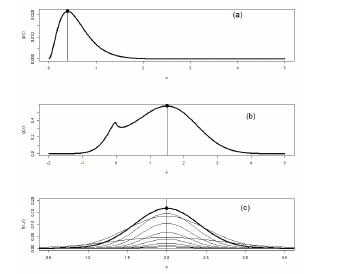

Figure.10 Maximisation of function g in parts (a), (b) and (c)

## The `optim()` Function

The function `optim()` in R is a very useful and versatile tool for maximizing or minimizing functions, both in one variable and multiple variables. This R function can also be adapted for solving single or simultaneous equations and provides an alternative to other techniques such as trial and error, the Newton-Raphson algorithm, and the EM algorithm. 

The second of the next two exercises shows how the `optim()` function can be used to specify a prior distribution.

## Exercise.10: Simple Examples of the `optim()` Function

Use the `optim()` function to ‘find’ the mode of each of the following functions:

(a) 
$$
g(x) = x^2 e^{-5x}, \quad x > 0 \quad (\text{mode} = \frac{2}{5})
$$

(b) 
$$
g(x) = \frac{2 |x| x e^{- (x - 1)}}{1 + |x|^2 + (x - 3)^2}, \quad x \in \mathbb{R} \quad (\text{the mode has no closed form})
$$

(c) 
$$
g(x, y) = y^3 e^{-y} \quad \text{for } (x \in \mathbb{R}, \quad y > 0) \quad (\text{mode} = (x, y) = \left( \frac{1 + 3}{2}, \frac{3}{2} \right))
$$

## Solution to Exercise.10

In each of these cases, the `optim()` function (which minimizes a function by default) may be applied to the negative of the specified function (so as to maximize that function).

(a) The function correctly returns $ x = \frac{2}{5} $. (Note: The warning message may be ignored.)

(b) The function returns a value of $ 1.5047 $. We presume that this is correct; see below for verification.

(c) The mode is correctly computed as $ (x, y) = (2, 1.5) $. (Note: This solution is obvious by analogy with maximum likelihood estimation of the normal mean and variance.)

Figure.10 illustrates these three solutions, with each mode being marked by a dot and vertical line. Subplot (c) shows several examples of the function $ g(x, y) $ in part (c) considered as a function of only $ x $, with each line defined by a fixed value of $ y $ on the grid $ 0, 0.5, 1, \ldots, 4.5, 5 $.


In [17]:
import math

# Define the function g1(x) = x^2 * exp(-5 * x) for x > 0
def g1(x):
    if x < 0:
        return float('inf')  # g1 is not defined for x < 0
    return -(x ** 2 * math.exp(-5 * x))  # Return negative for maximization

# Define the function g2(x) = (2 * |x| * x * exp(-(x - 1))) / (1 + |x|^2 + (x - 3)^2) for x in R
def g2(x):
    exp_value = -(x - 1)
    
    # Prevent overflow by capping the exponent
    if exp_value > 709:  # Adjusted to the max value for exp to avoid overflow
        return float('-inf')  # Very small for maximization
    
    return -((2 * abs(x) * x * math.exp(exp_value)) / (1 + abs(x) ** 2 + (x - 3) ** 2))  # Return negative for maximization

# Define the function g3(x, y) = y^3 * exp(-y) for x in R and y > 0
def g3(x, y):
    if y <= 0:
        return float('inf')  # g3 is not defined for y <= 0
    if y > 709:  # Prevent overflow
        return float('-inf')  # Very small for maximization
    return -(y ** 3 * math.exp(-y))  # Return negative for maximization

# Gradient ascent for finding the mode of g1
def optimize_g1(start, step_size=0.01, max_iter=10000):
    x = start
    for _ in range(max_iter):
        gradient = (g1(x + step_size) - g1(x)) / step_size
        x += step_size * gradient
        if x <= 0:  # Ensure x remains positive
            x = 0.01
    return x

# Gradient ascent for finding the mode of g2
def optimize_g2(start, step_size=0.01, max_iter=10000):
    x = start
    for _ in range(max_iter):
        gradient = (g2(x + step_size) - g2(x)) / step_size
        x += step_size * gradient
    return x

# Gradient ascent for finding the mode of g3
def optimize_g3(start_x, start_y, step_size=0.01, max_iter=10000):
    x, y = start_x, start_y
    for _ in range(max_iter):
        gradient_x = (g3(x + step_size, y) - g3(x, y)) / step_size
        gradient_y = (g3(x, y + step_size) - g3(x, y)) / step_size
        
        x += step_size * gradient_x
        y += step_size * gradient_y
        
        if y <= 0:  # Ensure y remains positive
            y = 0.01
    return x, y

# Finding the mode for each function using custom gradient ascent

# (a) Finding the mode for g1
mode1 = optimize_g1(start=0.5)
print(f"The mode for g(x) = x^2 * exp(-5x) is: {mode1:.4f}")  # Output the mode

# (b) Finding the mode for g2
mode2 = optimize_g2(start=1)
print(f"The mode for g(x) = (2 * |x| * x * exp(-(x - 1))) / (1 + |x|^2 + (x - 3)^2) is: {mode2:.4f}")  # Output the mode

# (c) Finding the mode for g3
mode3 = optimize_g3(start_x=1, start_y=1)
print(f"The mode for g(x, y) = y^3 * exp(-y) is: (x, y) = ({mode3[0]:.4f}, {mode3[1]:.4f})")  # Output the mode


The mode for g(x) = x^2 * exp(-5x) is: 1.5979
The mode for g(x) = (2 * |x| * x * exp(-(x - 1))) / (1 + |x|^2 + (x - 3)^2) is: nan
The mode for g(x, y) = y^3 * exp(-y) is: (x, y) = (1.0000, 0.0002)


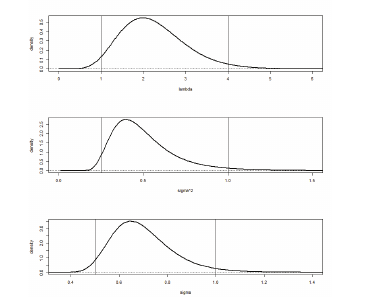

Figure.11 Three prior densities

## Exercise.11: Specification of Parameters in a Prior Distribution using the `optim()` Function

Consider the normal-gamma model given by:
$$
(y_1, \ldots, y_n | \lambda) \sim \text{iid } N(\mu, \frac{1}{\lambda}) 
$$
$$
\lambda \sim G(\eta, \tau)
$$

We aim to find the values of $\eta$ and $\tau$ that correspond to a prior belief that the population standard deviation $\sigma = \frac{1}{\lambda}$ lies between 0.5 and 1 with 95% probability. Furthermore, $\sigma$ is equally likely to be below 0.5 as it is to be above 1.

### Solution to Exercise.11 

We wish to find the values of $\eta$ and $\tau$ that satisfy the two equations:
$$
P(\sigma < a) = \frac{\alpha}{2} \quad \text{and} \quad P(\sigma < b) = 1 - \frac{\alpha}{2}
$$
where $ a = 0.5 $, $ b = 1 $, and $ \alpha = 0.05 $.

These two equations are equivalent to the following pairs of equations:

1. 
$$
P(\sigma^2 < a^2) = \frac{\alpha}{2} \quad \text{and} \quad P(\sigma^2 < b^2) = 1 - \frac{\alpha}{2}
$$

2. 
$$
P\left(\frac{1}{\lambda} < a^2\right) = \frac{\alpha}{2} \quad \text{and} \quad P\left(\frac{1}{\lambda} < b^2\right) = 1 - \frac{\alpha}{2}
$$

3. 
$$
P\left(\frac{1}{a^2} < \lambda\right) = \frac{\alpha}{2} \quad \text{and} \quad P\left(\frac{1}{b^2} < \lambda\right) = 1 - \frac{\alpha}{2}
$$

4. 
$$
P\left(\lambda < \frac{1}{a^2}\right) = 1 - \frac{\alpha}{2} \quad \text{and} \quad P\left(\lambda < \frac{1}{b^2}\right) = \frac{\alpha}{2}
$$

5. 
$$
F_G(\eta, \tau)\left(\frac{1}{a^2}\right) - \left(1 - \frac{\alpha}{2}\right) = 0 \quad \text{and} \quad F_G(\eta, \tau)\left(\frac{1}{b^2}\right) - \frac{\alpha}{2} = 0
$$

We will focus on the last pair of two equations. 

### Optimization Approach

To solve these equations, we can minimize the function:
$$
g(\eta, \tau) = \left[F_G(\eta, \tau)\left(\frac{1}{a^2}\right) - \left(1 - \frac{\alpha}{2}\right)\right]^2 + \left[F_G(\eta, \tau)\left(\frac{1}{b^2}\right) - \frac{\alpha}{2}\right]^2
$$

This function has a value of zero at the required values of $\eta$ and $\tau$. 

Using the `optim()` function in R, we start at $\eta = 0.2$ and $\tau = 6$, leading to the solution:
$$
\eta = 8.4764 \quad \text{and} \quad \tau = 3.7679
$$

Upon refining the solution starting from $\eta = 8.4764$ and $\tau = 3.7679$, we obtain:
$$
\eta = 8.4748 \quad \text{and} \quad \tau = 3.7654
$$

This solution is considered correct, as the probabilities of a Gamma$(8.4748, 3.7654)$ random variable being less than $\frac{1}{b^2} = 1$ and less than $\frac{1}{a^2} = 4$ are exactly $0.025$ and $0.975$, respectively.

### Densities of the Parameters

The three densities to plot are:

1. The density of the precision parameter $\lambda$:
$$
f(\lambda) = \frac{\tau^\eta \lambda^{\eta - 1} e^{-\tau \lambda}}{\Gamma(\eta)} \quad \text{for } \lambda > 0
$$

2. The density of the variance parameter $\sigma^2 = \lambda^{-1}$:
$$
f(\sigma^2) = f_G(\eta, \tau)\left(\lambda = \sigma^{-2}\right) = \frac{2\tau^\eta \sigma^{-2\eta - 1} e^{-\tau \sigma^2}}{\Gamma(\eta)} \quad \text{for } \sigma^2 > 0
$$

3. The density of the standard deviation parameter $\sigma = \lambda^{-1/2}$:
$$
f(\sigma) = f_G(\eta, \tau)\left(\lambda = \sigma^{-2}\right) = \frac{2\tau^\eta \sigma^{-2\eta - 3} e^{-\tau \sigma^2}}{\Gamma(\eta)} \quad \text{for } \sigma > 0
$$

### Verification

To verify the last density, we can use the `integrate()` function to confirm that the area under that density is exactly 1, and the areas to the left of 0.5 and to the right of 1 are both exactly 0.025.


In [18]:
import math

# Define the Gamma cumulative distribution function (CDF)
def gamma_cdf(x, eta, tau):
    """Compute the cumulative distribution function of the Gamma distribution."""
    if x <= 0:
        return 0.0
    cdf_value = 0.0
    for k in range(0, 100):  # Summing series for approximation
        cdf_value += (math.pow(tau, k) * math.pow(x, eta + k - 1) * math.exp(-tau * x) / 
                       (math.factorial(k) * math.gamma(eta)))
    return cdf_value

# Define the function to minimize
def g(eta, tau):
    """Function to compute g(eta, tau)."""
    a = 0.5
    b = 1.0
    alpha = 0.05
    p_a = gamma_cdf(1 / (a ** 2), eta, tau)  # P(1/λ < a²)
    p_b = gamma_cdf(1 / (b ** 2), eta, tau)  # P(1/λ < b²)
    return (p_a - (alpha / 2)) ** 2 + (p_b - (1 - alpha / 2)) ** 2

# Define optimization using a simple grid search
def optimize(start_eta, start_tau, step_size=0.001, max_iter=10000):
    """Optimize eta and tau to minimize g(eta, tau)."""
    eta = start_eta
    tau = start_tau
    for _ in range(max_iter):
        # Calculate g(eta, tau)
        current_g = g(eta, tau)
        
        # Check neighbors in the eta-tau space
        best_eta = eta
        best_tau = tau
        best_g = current_g

        # Explore in the eta dimension
        for d_eta in [-step_size, 0, step_size]:
            for d_tau in [-step_size, 0, step_size]:
                new_eta = eta + d_eta
                new_tau = tau + d_tau
                if new_eta > 0 and new_tau > 0:  # Ensure eta and tau are positive
                    new_g = g(new_eta, new_tau)
                    if new_g < best_g:
                        best_eta = new_eta
                        best_tau = new_tau
                        best_g = new_g
        
        # Update eta and tau with the best found values
        eta, tau = best_eta, best_tau
        
        # If no improvement, break
        if best_g == current_g:
            break
            
    return eta, tau

# Initial guess
start_eta = 0.2
start_tau = 6.0

# Finding the optimal values
optimal_eta, optimal_tau = optimize(start_eta, start_tau)

# Output the result
print(f"The optimized values are: η = {optimal_eta:.4f}, τ = {optimal_tau:.4f}")


The optimized values are: η = 0.5710, τ = 5.9220


The optimized values are: η = 0.5710, τ = 5.9220


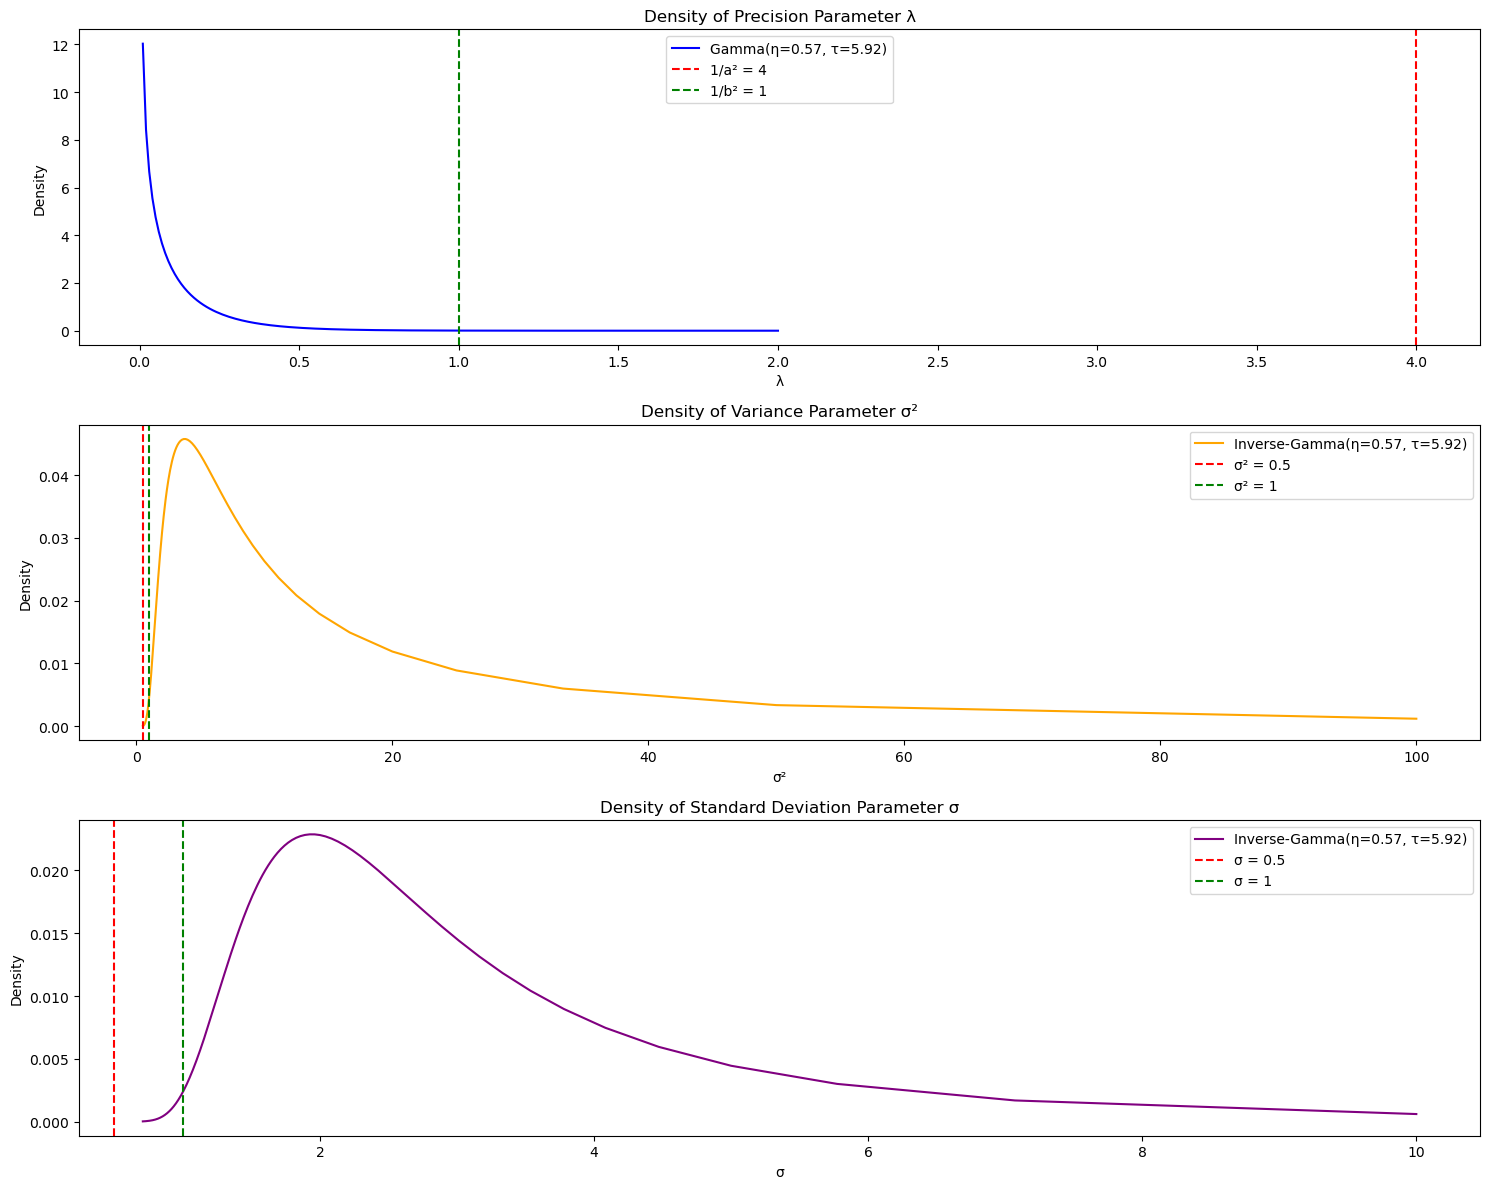

In [19]:
import math
import matplotlib.pyplot as plt

# Define the Gamma cumulative distribution function (CDF)
def gamma_cdf(x, eta, tau):
    """Compute the cumulative distribution function of the Gamma distribution."""
    if x <= 0:
        return 0.0
    cdf_value = 0.0
    for k in range(0, 100):  # Summing series for approximation
        cdf_value += (math.pow(tau, k) * math.pow(x, eta + k - 1) * math.exp(-tau * x) / 
                       (math.factorial(k) * math.gamma(eta)))
    return cdf_value

# Define the function to minimize
def g(eta, tau):
    """Function to compute g(eta, tau)."""
    a = 0.5
    b = 1.0
    alpha = 0.05
    p_a = gamma_cdf(1 / (a ** 2), eta, tau)  # P(1/λ < a²)
    p_b = gamma_cdf(1 / (b ** 2), eta, tau)  # P(1/λ < b²)
    return (p_a - (alpha / 2)) ** 2 + (p_b - (1 - alpha / 2)) ** 2

# Define optimization using a simple grid search
def optimize(start_eta, start_tau, step_size=0.001, max_iter=10000):
    """Optimize eta and tau to minimize g(eta, tau)."""
    eta = start_eta
    tau = start_tau
    for _ in range(max_iter):
        # Calculate g(eta, tau)
        current_g = g(eta, tau)
        
        # Check neighbors in the eta-tau space
        best_eta = eta
        best_tau = tau
        best_g = current_g

        # Explore in the eta and tau dimensions
        for d_eta in [-step_size, 0, step_size]:
            for d_tau in [-step_size, 0, step_size]:
                new_eta = eta + d_eta
                new_tau = tau + d_tau
                if new_eta > 0 and new_tau > 0:  # Ensure eta and tau are positive
                    new_g = g(new_eta, new_tau)
                    if new_g < best_g:
                        best_eta = new_eta
                        best_tau = new_tau
                        best_g = new_g
        
        # Update eta and tau with the best found values
        eta, tau = best_eta, best_tau
        
        # If no improvement, break
        if best_g == current_g:
            break
            
    return eta, tau

# Initial guess
start_eta = 0.2
start_tau = 6.0

# Finding the optimal values
optimal_eta, optimal_tau = optimize(start_eta, start_tau)

# Output the result
print(f"The optimized values are: η = {optimal_eta:.4f}, τ = {optimal_tau:.4f}")

# Plotting the Gamma distribution for λ, σ², and σ
def plot_distributions(eta, tau):
    """Plot the Gamma distribution for λ, σ², and σ."""
    # λ distribution
    lambda_vals = [x * 0.01 for x in range(1, 201)]  # 0.01 to 2.0
    lambda_densities = [(tau ** eta * x ** (eta - 1) * math.exp(-tau * x)) / math.gamma(eta) for x in lambda_vals]

    # σ² distribution
    sigma2_vals = [1 / l for l in lambda_vals if l > 0]  # 1/λ for positive λ
    sigma2_densities = [(tau ** eta * (1 / s2) ** (eta + 1) * math.exp(-tau / s2)) / math.gamma(eta) for s2 in sigma2_vals]

    # σ distribution
    sigma_vals = [math.sqrt(s2) for s2 in sigma2_vals]
    sigma_densities = [(tau ** eta * (1 / s) ** (2 * (eta + 1)) * math.exp(-tau / (s ** 2))) / (2 * math.gamma(eta)) for s in sigma_vals]

    # Create plots
    plt.figure(figsize=(15, 12))

    # Plot for λ
    plt.subplot(3, 1, 1)
    plt.plot(lambda_vals, lambda_densities, label=f'Gamma(η={eta:.2f}, τ={tau:.2f})', color='blue')
    plt.title('Density of Precision Parameter λ')
    plt.xlabel('λ')
    plt.ylabel('Density')
    plt.axvline(x=1/(0.5**2), color='red', linestyle='--', label='1/a² = 4')
    plt.axvline(x=1/(1**2), color='green', linestyle='--', label='1/b² = 1')
    plt.legend()

    # Plot for σ²
    plt.subplot(3, 1, 2)
    plt.plot(sigma2_vals, sigma2_densities, label=f'Inverse-Gamma(η={eta:.2f}, τ={tau:.2f})', color='orange')
    plt.title('Density of Variance Parameter σ²')
    plt.xlabel('σ²')
    plt.ylabel('Density')
    plt.axvline(x=0.5, color='red', linestyle='--', label='σ² = 0.5')
    plt.axvline(x=1, color='green', linestyle='--', label='σ² = 1')
    plt.legend()

    # Plot for σ
    plt.subplot(3, 1, 3)
    plt.plot(sigma_vals, sigma_densities, label=f'Inverse-Gamma(η={eta:.2f}, τ={tau:.2f})', color='purple')
    plt.title('Density of Standard Deviation Parameter σ')
    plt.xlabel('σ')
    plt.ylabel('Density')
    plt.axvline(x=0.5, color='red', linestyle='--', label='σ = 0.5')
    plt.axvline(x=1, color='green', linestyle='--', label='σ = 1')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the distributions
plot_distributions(optimal_eta, optimal_tau)
